<a href="https://colab.research.google.com/github/arturoliduena/cifar10-image-recognition/blob/main/versions/cnn_cifar10_tf2_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Librerias & Google Drive

Para empezar carguemos esas librerias que nos hacen falta

In [23]:
from tensorflow import keras as ks
from matplotlib import pyplot as plt
import numpy as np
import time
import datetime

Incorporamos la carpeta de Google Drive para poder "guardar" nuestros modelos

1. Abrir barra lateral de Carpeta
2.  Hacer click en carpeta con logo de Google Drive


In [24]:
# Aquí iria el codigo para conectarse a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Arquitectura de red del modelo - Proyecto 0


In [25]:
model = ks.Sequential()

model.add(ks.layers.Conv2D(16, (3, 3), strides=1, activation='relu', 
                           padding='same', input_shape=(32,32,3)))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dense(10, activation='softmax'))


Para revisar un modelo, nos basta con llamar al método **.summary()** del modelo

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        9280      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 128)       

## 3. Optimizador, función error


In [27]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 4. Preparamos los datos

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:** 
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [28]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0

In [29]:
y_train_label = y_train

y_test
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

Obtenemos un array con todas las labels de CIFAR10

In [30]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


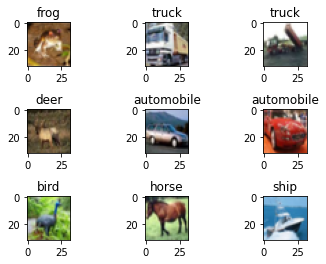

In [31]:
# Pintemos una muestra de las las imagenes del dataset MNIST

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train_label[i,0]])

plt.subplots_adjust(hspace = 1)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [32]:
x_val_scaled = x_train_scaled[-10000:]
y_val = y_train[-10000:]

x_train_scaled = x_train_scaled[:-10000]
y_train = y_train[:-10000]


Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución espera una matriz de 4 campos** (más parecido a "imagenes"), en el caso de MNIST. CIFAR10 ya tiene el shape adecuado, así que no tenemos que hacer nada, pero como siempre decimos: es mejor que comprobeis su tamaño.

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [33]:
# Validamos el resultado
print('Train: X=%s, y=%s' % (x_train_scaled.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test_scaled.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val_scaled.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
Validation: X=(10000, 32, 32, 3), y=(10000, 1)


## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 64

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

## 5.1 Callbacks

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
# Callback con EarlyStopping basado en Accuracy
callback_accuracy = EarlyStopping(monitor='val_accuracy', patience=5)

# Callback con EarlyStopping basada en Loss
callback_loss = EarlyStopping(monitor='val_loss', patience=5)

In [36]:
t = time.perf_counter()

In [37]:
history = model.fit(x_train_scaled, y_train, epochs=200, 
                    use_multiprocessing=False, batch_size= 512, callbacks=[callback_loss, callback_accuracy],
                    validation_data=(x_val_scaled, y_val))

Epoch 1/200
79/79 [==============================] - 4s 39ms/step - loss: 1.8502 - accuracy: 0.3213 - val_loss: 1.6516 - val_accuracy: 0.4026
Epoch 2/200
79/79 [==============================] - 3s 32ms/step - loss: 1.5218 - accuracy: 0.4499 - val_loss: 1.4434 - val_accuracy: 0.4817
Epoch 3/200
79/79 [==============================] - 3s 35ms/step - loss: 1.3735 - accuracy: 0.5088 - val_loss: 1.3628 - val_accuracy: 0.5112
Epoch 4/200
79/79 [==============================] - 3s 32ms/step - loss: 1.2766 - accuracy: 0.5479 - val_loss: 1.2772 - val_accuracy: 0.5459
Epoch 5/200
79/79 [==============================] - 3s 32ms/step - loss: 1.2013 - accuracy: 0.5775 - val_loss: 1.2338 - val_accuracy: 0.5615
Epoch 6/200
79/79 [==============================] - 3s 32ms/step - loss: 1.1430 - accuracy: 0.5981 - val_loss: 1.2436 - val_accuracy: 0.5574
Epoch 7/200
79/79 [==============================] - 3s 33ms/step - loss: 1.0956 - accuracy: 0.6150 - val_loss: 1.1359 - val_accuracy: 0.6035
Epoch 

In [38]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:01:10.944929


## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

In [39]:
_, acc = model.evaluate(x_test_scaled, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 68.590


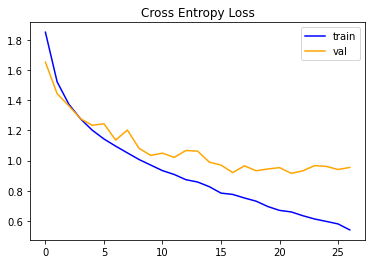

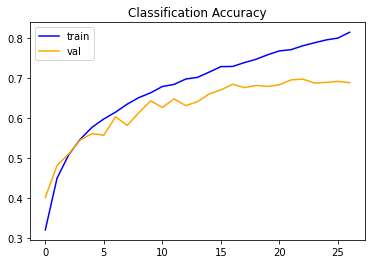

In [40]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

El coste podemos ver que es estable y es en el epoch 15 que se fija en un valor. Además la accuracy baila alrededor de 0.10. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [41]:
predictions = model.predict(x_test)

Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [42]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


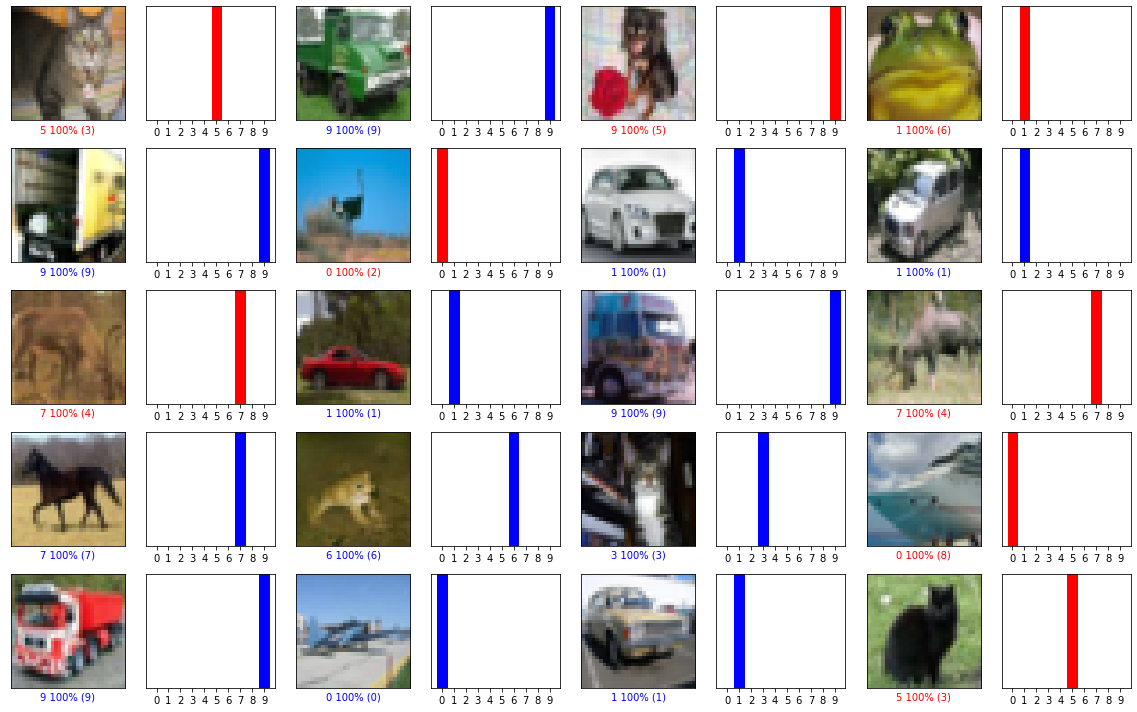

In [43]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

## 7. Guardamos el modelo para futuras evaluaciones

Id cambiando los nombres del archivo para ir guardando los diversos proyectos.
Aquí lo guardamos en "local", pero recordad que lo ideal es que lo guardeis en Google Drive (teneis que montar la unidad, fijar la ruta y allí guardar el modelo .h5)

In [44]:
ruta_googledrive = "/content/drive/MyDrive/" # A revisar en vuestra instancia

model.save(ruta_googledrive+'cifar10_base_model.h5')